## Calculate metrics across TFT and Mamba models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set working directory to '/n/groups/patel/shakson/aiready/'
import os
os.chdir("/home/shaksonisaac/CGM/mambatf/")

#LOAD Datasets
import pandas as pd
import io
from google.cloud import storage

_BUCKET_NAME = "cgmproject2025"

# Download dataset from GCS
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/train_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
train = pd.read_feather(io.BytesIO(data_bytes))


# Download test set:
client = storage.Client()
bucket = client.bucket(_BUCKET_NAME)
blob = bucket.blob('ai-ready/data/test_finaltimeseries_meal.feather')
data_bytes = blob.download_as_bytes()
test = pd.read_feather(io.BytesIO(data_bytes))

## Common Functions

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats

def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )

def quantile_loss(y_true, y_pred, q=0.5):
    return np.mean(np.maximum(q * (y_true - y_pred), (q - 1) * (y_true - y_pred)))

def calculate_metrics(t_grouped, train_df):
    static_vars = train_df[
        [
            "participant_id",
        ]
    ].drop_duplicates()
    t_grouped = t_grouped.merge(static_vars, on="participant_id", how="left")
    metrics_df = (
        t_grouped.groupby("participant_id")
        .apply(
            lambda df: pd.Series(
                {
                    "SMAPE": smape(df["target"], df["prediction"]),
                    "Quantile_Loss": quantile_loss(df["target"], df["prediction"]),
                    "MAE": np.mean(np.abs(df["prediction"] - df["target"])),
                    "RMSE": np.sqrt(np.mean(np.square(df["prediction"] - df["target"]))),
                }
            )
        )
        .reset_index()
    )
    return metrics_df

def get_confidence_intervals(df, metric, confidence=0.95):
    mean = df[metric].mean()
    sem = stats.sem(df[metric])  # Standard Error of the Mean
    margin_of_error = sem * stats.t.ppf((1 + confidence) / 2, len(df) - 1)
    return mean, mean - margin_of_error, mean + margin_of_error

def calculate_metrics_CI(records, train):
    """
    Calculate metrics for each participant in the records DataFrame.
    """
    metrics_df = calculate_metrics(records, train)

    confidence_intervals = {}
    for metric in ["SMAPE", "MAE", "RMSE", "Quantile_Loss"]:
        mean, lower, upper = get_confidence_intervals(metrics_df, metric)
        confidence_intervals[metric] = {
            "mean": mean,
            "lower": lower,
            "upper": upper
        }
    # Convert to DataFrame for better visualization
    confidence_df = pd.DataFrame(confidence_intervals).T.reset_index()
    confidence_df.columns = ["Metric", "Mean", "Lower CI", "Upper CI"]
    return confidence_df

In [4]:
import gc
def clear_memory():
    gc.collect()
    import torch
    torch.cuda.empty_cache()
clear_memory()

In [5]:
import os, re
from google.cloud import storage

def download_best_ckpt_by_filename(local_dir: str, bucket_name: str, gcs_prefix: str,
                                   run_prefix: str = "tft576-", metric_key: str = "val_loss"):
    """
    Finds the .ckpt with the smallest {metric_key} in its filename under gcs_prefix,
    e.g., 'tft576-epoch=17-val_loss=3.61.ckpt', downloads it, and returns the local path.
    """
    os.makedirs(local_dir, exist_ok=True)
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    blobs = [b for b in bucket.list_blobs(prefix=gcs_prefix)
             if b.name.endswith(".ckpt")
             and "last.ckpt" not in b.name
             and run_prefix in os.path.basename(b.name)
             and f"{metric_key}=" in os.path.basename(b.name)]

    if not blobs:
        raise FileNotFoundError(f"No epoch checkpoints with {metric_key}=... under gs://{bucket_name}/{gcs_prefix}")

    rx = re.compile(rf"{metric_key}=([0-9]+\.[0-9]+)")
    def score(b):
        m = rx.search(os.path.basename(b.name))
        return float(m.group(1)) if m else float("inf")

    best_blob = min(blobs, key=score)
    local_path = os.path.join(local_dir, os.path.basename(best_blob.name))
    best_blob.download_to_filename(local_path)
    print(f"Downloaded best checkpoint: gs://{bucket_name}/{best_blob.name} -> {local_path}")
    return local_path


# TFT (144)

In [6]:
# Load Data
import os
import sys
import torch

# Fetch best ckpt from GCS (use your actual bucket/prefix)
BUCKET = "cgmproject2025"
GCS_PREFIX = "checkpoints_tft_144"   # <- change if your run used a different folder
best_ckpt_path = download_best_ckpt_by_filename("checkpoints", BUCKET, GCS_PREFIX,
                                                run_prefix="tft144-", metric_key="val_loss")

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.tft144 import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs, TemporalFusionTransformer

# Rebuild the training dataset (same context_length, horizon, etc.)
training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=144, batchsize=32)

# Load model from the checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
tft = TemporalFusionTransformer.load_from_checkpoint(best_ckpt_path, map_location=device).to(device)
tft.eval()

Downloaded best checkpoint: gs://cgmproject2025/checkpoints_tft_144/tft144-epoch=14-val_loss=3.86.ckpt -> checkpoints/tft144-epoch=14-val_loss=3.86.ckpt


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-08-31 18:23:39.614131] Start of Dataloader Creation
GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


TemporalFusionTransformer(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 144, 'min_encoder_length': 144, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdif

In [7]:
# Get global metrics:
raw_preds = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
print("Shape of raw_preds:", raw_preds.output["prediction"].shape)
y_pred = raw_preds.output["prediction"][:, :, 1] #To get median quantile.
y_true = raw_preds.x["decoder_target"]
index_df = raw_preds.index
records = []
for i in range(len(index_df)):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    for t in range(y_pred.shape[1]):
        records.append({
            "participant_id": uid,
            "ds": int(time_start + t),
            "target": float(y_true[i, t]),
            "prediction": float(y_pred[i, t]),
        })
records = pd.DataFrame(records)

metricsCI = calculate_metrics_CI(records, train)
print(metricsCI)

# Save metrics locally
metricsCI.to_csv("./figures/metrics_tft_144.csv", index=False)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `

Shape of raw_preds: torch.Size([741, 12, 3])
          Metric      Mean  Lower CI  Upper CI
0          SMAPE  4.604538  4.381032  4.828043
1            MAE  6.064935  5.760918  6.368951
2           RMSE  7.321692  6.957817  7.685567
3  Quantile_Loss  3.032467  2.880459  3.184475


/tmp/ipykernel_2335/1184106390.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [8]:
# Get confidence intervals for quantile loss

from pytorch_forecasting.metrics import QuantileLoss

# Keep individual losses
loss_fn = QuantileLoss(quantiles=[0.1, 0.5, 0.9], reduction="none").to(device)  # uses same quantiles as model

# Usage with your tensors:
pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device


losses = loss_fn(pred, true)  # shape: (B, T, Q)

import torch

# Flatten across batch, time, and quantiles
losses_flat = losses.view(-1).detach().cpu()

mean_loss = losses_flat.mean().item()
std_loss = losses_flat.std().item()

# 95% confidence interval (normal approximation)
n = losses_flat.numel()
ci95 = 1.96 * std_loss / (n**0.5)

print(f"Mean loss: {mean_loss:.4f} ± {ci95:.4f}")


print(f"Mean loss: {mean_loss - ci95}, {mean_loss + ci95}")

Mean loss: 3.9530 ± 0.0645
Mean loss: 3.8884778789082874, 4.017484111448158


# TFT (288)

In [23]:
# Load Data
import os
import sys
import torch

# Fetch best ckpt from GCS (use your actual bucket/prefix)
BUCKET = "cgmproject2025"
GCS_PREFIX = "checkpoints_tft_288v3"   # <- change if your run used a different folder
best_ckpt_path = download_best_ckpt_by_filename("checkpoints", BUCKET, GCS_PREFIX,
                                                run_prefix="tft288-", metric_key="val_loss")

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.tft288 import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs, TemporalFusionTransformer

# Rebuild the training dataset (same context_length, horizon, etc.)
training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=288, batchsize=32)

# Load model from the checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
tft = TemporalFusionTransformer.load_from_checkpoint(best_ckpt_path, map_location=device).to(device)
tft.eval()


# tft = load_tft_from_gcs(model_name="TFT_12h_288cv3", training_dataset=training)
# tft.eval()  # Put model in evaluation mode

# # --- Prédiction ---
# # Assure-toi que val_dataloader est bien structuré
# y_hat_raw = tft.predict(val_dataloader, mode="raw")
# # --- Visualisation des interprétations ---
# interpretation = tft.interpret_output(y_hat_raw, reduction="sum")
# tft.plot_interpretation(interpretation)

Downloaded best checkpoint: gs://cgmproject2025/checkpoints_tft_288v3/tft288-epoch=16-val_loss=3.98.ckpt -> checkpoints/tft288-epoch=16-val_loss=3.98.ckpt
[2025-08-27 22:10:16.961711] Start of Dataloader Creation
GPU Mem allocated: 10.79 GB | reserved: 11.18 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


TemporalFusionTransformer(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 288, 'min_encoder_length': 288, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdif

In [24]:
# Get global metrics:
raw_preds = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
print("Shape of raw_preds:", raw_preds.output["prediction"].shape)
y_pred = raw_preds.output["prediction"][:, :, 1] #To get median quantile.
y_true = raw_preds.x["decoder_target"]
index_df = raw_preds.index
records = []
for i in range(len(index_df)):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    for t in range(y_pred.shape[1]):
        records.append({
            "participant_id": uid,
            "ds": int(time_start + t),
            "target": float(y_true[i, t]),
            "prediction": float(y_pred[i, t]),
        })
records = pd.DataFrame(records)

metricsCI = calculate_metrics_CI(records, train)
print(metricsCI)

# Save metrics locally
metricsCI.to_csv("./figures/metrics_tft_288.csv", index=False)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Shape of raw_preds: torch.Size([741, 12, 3])
          Metric      Mean  Lower CI  Upper CI
0          SMAPE  4.626611  4.410413  4.842808
1            MAE  6.062525  5.767106  6.357944
2           RMSE  7.280245  6.928085  7.632405
3  Quantile_Loss  3.031263  2.883553  3.178972


/tmp/ipykernel_28256/1184106390.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [25]:
from pytorch_forecasting.metrics import QuantileLoss

loss_fn = QuantileLoss(quantiles=[0.1, 0.5, 0.9])  # uses same quantiles as model


# Usage with your tensors:
pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device

#Shape of pred:
print("Shape of pred:", pred.shape)

#Shape of true:
print("Shape of true:", true.shape)

print("Quantiles used in loss function:", tft.loss.quantiles)

val_loss = loss_fn(pred, true)
print("Validation Quantile Loss (using pytorch-forecasting):", val_loss.item())

Shape of pred: torch.Size([741, 12, 3])
Shape of true: torch.Size([741, 12])
Quantiles used in loss function: [0.1, 0.5, 0.9]
Validation Quantile Loss (using pytorch-forecasting): 3.922172784805298


In [26]:
# Get confidence intervals for quantile loss

from pytorch_forecasting.metrics import QuantileLoss

# Keep individual losses
loss_fn = QuantileLoss(quantiles=[0.1, 0.5, 0.9], reduction="none").to(device)  # uses same quantiles as model

# Usage with your tensors:
pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device


losses = loss_fn(pred, true)  # shape: (B, T, Q)

import torch

# Flatten across batch, time, and quantiles
losses_flat = losses.view(-1).detach().cpu()

mean_loss = losses_flat.mean().item()
std_loss = losses_flat.std().item()

# 95% confidence interval (normal approximation)
n = losses_flat.numel()
ci95 = 1.96 * std_loss / (n**0.5)

print(f"Mean loss: {mean_loss:.4f} ± {ci95:.4f}")


print(f"Mean loss: {mean_loss - ci95}, {mean_loss + ci95}")

Mean loss: 3.9222 ± 0.0636
Mean loss: 3.8585540707227737, 3.985791022050664


In [6]:
# --- Build test with encoder context ---
context_length = 288     # = max_encoder_length used in 'training'
horizon = 12             # = max_prediction_length used in 'training'
time_col = "ds"          # must match the 'time_idx' you used for 'training'
gid_col = "participant_id"

combined = []
for pid, test_part in test.groupby(gid_col):
    train_part = train.loc[train[gid_col].eq(pid)].sort_values(time_col)
    # if a participant exists only in test, skip or handle separately
    if train_part.empty:
        continue
    enc = train_part.tail(min(len(train_part), context_length))
    tmp = pd.concat([enc, test_part], axis=0).sort_values(time_col)
    # ensure integer, strictly increasing time index if required by your dataset
    # tmp[time_col] = tmp[time_col].astype(int)  # uncomment if needed
    combined.append(tmp)

test_full = pd.concat(combined, axis=0).reset_index(drop=True)

# --- Build dataset/dataloader (re-uses all settings from 'training') ---
from pytorch_forecasting import TimeSeriesDataSet

test_ds = TimeSeriesDataSet.from_dataset(
    training,
    test_full,
    stop_randomization=True,
    predict=True,            # create one prediction window per series
)

test_dl = test_ds.to_dataloader(train=False, batch_size=32)

# --- Predict ---
import torch
tft.eval()
with torch.no_grad():
    out = tft.predict(test_dl, mode="raw", return_x=True, return_index=True)

# pick median quantile robustly
# works if your loss is QuantileLoss and model exposes quantiles
quantiles = getattr(tft, "quantiles", [0.1, 0.5, 0.9])
q_median_idx = int(quantiles.index(0.5)) if 0.5 in quantiles else 0  # fallback

pred = out.output["prediction"][:, :, q_median_idx]          # (n_windows, horizon)
true = out.x["decoder_target"]                                # (n_windows, horizon)
idx  = out.index                                              # DataFrame with group ids + start time_idx

# --- Reconstruct long-form records for metrics ---
records = []
for i in range(len(idx)):
    pid = idx.iloc[i][gid_col]
    t0  = idx.iloc[i][time_col]  # this is the decoder start time (first forecast step)
    for t in range(pred.shape[1]):
        records.append({
            gid_col: pid,
            time_col: int(t0 + t),
            "target": float(true[i, t]),
            "prediction": float(pred[i, t]),
        })

records = pd.DataFrame(records)

# optional: sanity checks
# assert records.groupby([gid_col, time_col]).size().eq(1).all()

metricsCI = calculate_metrics_CI(records, train)
print(metricsCI)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


          Metric       Mean   Lower CI   Upper CI
0          SMAPE   8.496876   8.037685   8.956067
1            MAE  11.411511  10.705621  12.117401
2           RMSE  13.631882  12.825144  14.438621
3  Quantile_Loss   5.705755   5.352811   6.058700


/tmp/ipykernel_3754/1184106390.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


# TFT (576)

In [19]:
# Load Data
import os
import sys
import torch

# Fetch best ckpt from GCS (use your actual bucket/prefix)
BUCKET = "cgmproject2025"
GCS_PREFIX = "checkpoints_tft_576v3"   # <- change if your run used a different folder
best_ckpt_path = download_best_ckpt_by_filename("checkpoints", BUCKET, GCS_PREFIX,
                                                run_prefix="tft576-", metric_key="val_loss")

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.tft576 import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs, TemporalFusionTransformer

# Rebuild the training dataset (same context_length, horizon, etc.)
training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=576, batchsize=32)

# Load model from the checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
tft = TemporalFusionTransformer.load_from_checkpoint(best_ckpt_path, map_location=device).to(device)
tft.eval()

Downloaded best checkpoint: gs://cgmproject2025/checkpoints_tft_576v3/tft576-epoch=17-val_loss=3.61.ckpt -> checkpoints/tft576-epoch=17-val_loss=3.61.ckpt
[2025-08-27 22:08:36.855281] Start of Dataloader Creation
GPU Mem allocated: 10.51 GB | reserved: 10.73 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


TemporalFusionTransformer(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 576, 'min_encoder_length': 576, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdif

/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-08-27 20:02:13.767400] Start of Dataloader Creation
GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. 

Loaded TFT from gs://cgmproject2025/models/predictions/TFT_12h_576cv3/


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x800 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

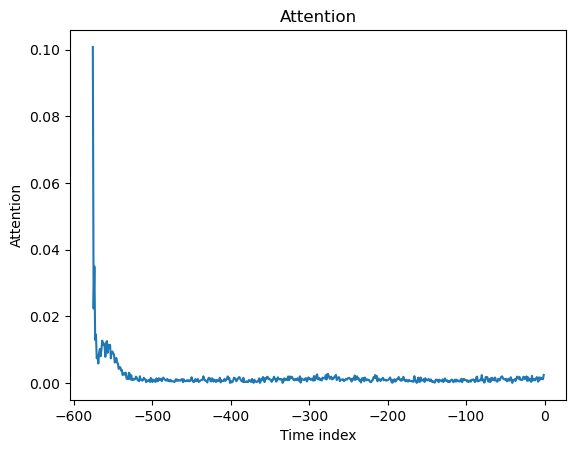

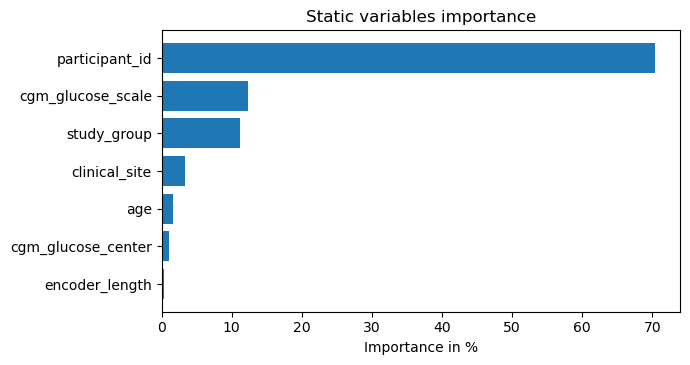

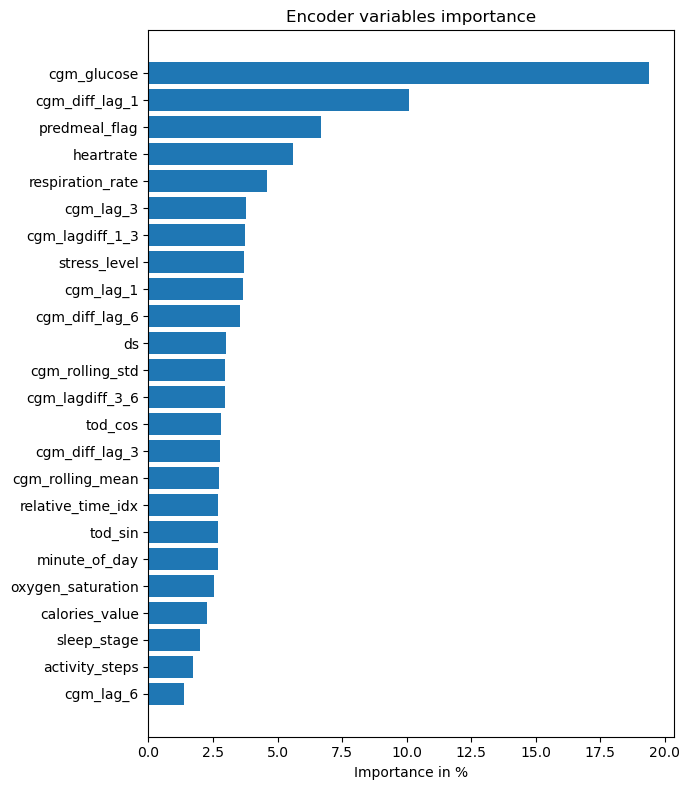

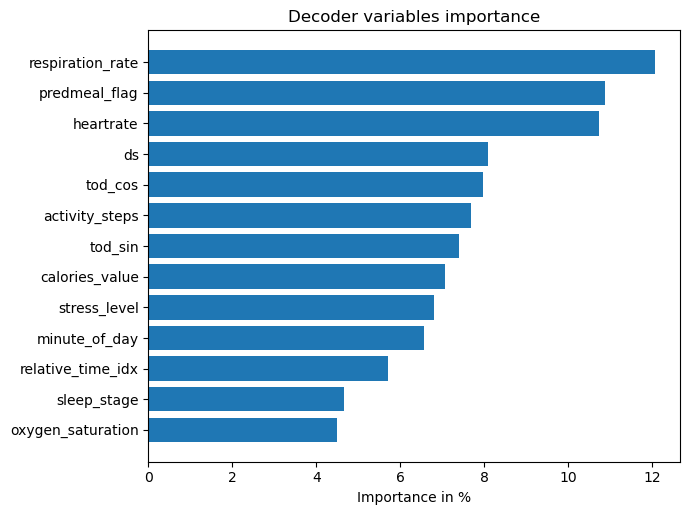

In [ ]:
# # Load Data
# import os
# import sys

# #from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
# from scripts.tft576 import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs

# # Rebuild the training dataset (same context_length, horizon, etc.)
# training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=576, batchsize=32)

# tft = load_tft_from_gcs(model_name="TFT_12h_576cv3", training_dataset=training)
# tft.eval()  # Put model in evaluation mode

# # --- Prédiction ---
# # Assure-toi que val_dataloader est bien structuré
# y_hat_raw = tft.predict(val_dataloader, mode="raw")
# # --- Visualisation des interprétations ---
# interpretation = tft.interpret_output(y_hat_raw, reduction="sum")
# tft.plot_interpretation(interpretation)

In [20]:
# Get global metrics:
raw_preds = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
print("Shape of raw_preds:", raw_preds.output["prediction"].shape)
y_pred = raw_preds.output["prediction"][:, :, 1] #To get median quantile.
y_true = raw_preds.x["decoder_target"]
index_df = raw_preds.index
records = []
for i in range(len(index_df)):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    for t in range(y_pred.shape[1]):
        records.append({
            "participant_id": uid,
            "ds": int(time_start + t),
            "target": float(y_true[i, t]),
            "prediction": float(y_pred[i, t]),
        })
records = pd.DataFrame(records)

metricsCI = calculate_metrics_CI(records, train)
print(metricsCI)

# Save metrics locally
metricsCI.to_csv("./figures/metrics_tft_576.csv", index=False)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Shape of raw_preds: torch.Size([741, 12, 3])
          Metric      Mean  Lower CI  Upper CI
0          SMAPE  4.403722  4.205237  4.602207
1            MAE  5.765812  5.499649  6.031974
2           RMSE  6.922433  6.605486  7.239379
3  Quantile_Loss  2.882906  2.749825  3.015987


/tmp/ipykernel_28256/1184106390.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [11]:
# import torch

# def torch_pinball_loss(y_true, y_pred, quantiles=(0.1, 0.5, 0.9), reduction="mean"):
#     """
#     y_true: (B, T) tensor
#     y_pred: (B, T, Q) tensor with Q=len(quantiles)
#     """
#     if not torch.is_tensor(y_true):
#         y_true = torch.as_tensor(y_true, device=y_pred.device)
#     if not torch.is_tensor(y_pred):
#         y_pred = torch.as_tensor(y_pred, device=y_true.device)

#     y_true = y_true.to(dtype=y_pred.dtype)
#     q = torch.as_tensor(quantiles, device=y_pred.device, dtype=y_pred.dtype).view(1, 1, -1)

#     e = y_true.unsqueeze(-1) - y_pred                   # (B, T, Q)
#     loss = torch.maximum(q * e, (q - 1) * e)            # pinball loss

#     if reduction == "mean":
#         return loss.mean()
#     elif reduction == "none":
#         return loss.mean(dim=(0, 1))                    # (Q,)
#     elif reduction == "sum":
#         return loss.sum()
#     else:
#         raise ValueError("reduction must be 'mean'|'none'|'sum'")

# # Usage with your tensors:
# pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
# true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device

# # Make sure quantiles correspond to your model's order
# quantiles = tuple(float(q) for q in getattr(tft.loss, "quantiles", (0.1, 0.5, 0.9)))
# print("Using quantiles:", quantiles)

# ql_all   = torch_pinball_loss(true, pred, quantiles, reduction="mean").item()

In [21]:
from pytorch_forecasting.metrics import QuantileLoss

loss_fn = QuantileLoss(quantiles=[0.1, 0.5, 0.9])  # uses same quantiles as model


# Usage with your tensors:
pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device

#Shape of pred:
print("Shape of pred:", pred.shape)

#Shape of true:
print("Shape of true:", true.shape)

print("Quantiles used in loss function:", tft.loss.quantiles)

val_loss = loss_fn(pred, true)
print("Validation Quantile Loss (using pytorch-forecasting):", val_loss.item())

Shape of pred: torch.Size([741, 12, 3])
Shape of true: torch.Size([741, 12])
Quantiles used in loss function: [0.1, 0.5, 0.9]
Validation Quantile Loss (using pytorch-forecasting): 3.699538230895996


In [22]:
# Get confidence intervals for quantile loss

from pytorch_forecasting.metrics import QuantileLoss

# Keep individual losses
loss_fn = QuantileLoss(quantiles=[0.1, 0.5, 0.9], reduction="none").to(device)  # uses same quantiles as model

# Usage with your tensors:
pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device


losses = loss_fn(pred, true)  # shape: (B, T, Q)

import torch

# Flatten across batch, time, and quantiles
losses_flat = losses.view(-1).detach().cpu()

mean_loss = losses_flat.mean().item()
std_loss = losses_flat.std().item()

# 95% confidence interval (normal approximation)
n = losses_flat.numel()
ci95 = 1.96 * std_loss / (n**0.5)

print(f"Mean loss: {mean_loss:.4f} ± {ci95:.4f}")


print(f"Mean loss: {mean_loss - ci95}, {mean_loss + ci95}")

Mean loss: 3.6995 ± 0.0574
Mean loss: 3.6421523580745303, 3.756924103717462


# MAMBA-MES (144 - 12 hours)

In [10]:
# Load Data
import os
import sys
import torch

# Fetch best ckpt from GCS (use your actual bucket/prefix)
BUCKET = "cgmproject2025"
GCS_PREFIX = "checkpoints_mamba144_MESv2"   # <- change if your run used a different folder
best_ckpt_path = download_best_ckpt_by_filename("checkpoints", BUCKET, GCS_PREFIX,
                                                run_prefix="mamba144_MES-", metric_key="val_loss")

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.mamba2_144_mes import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs, MambaTFT

param_24 = {
    "dataset": {"context_length": 144, "horizon": 12, "batch_size": 32},
    "mamba_tft_init": {"mamba_depth": 4, "mamba_dropout": 0.2},
    "mamba_block": {
        "d_model": 128,
        "dropout": 0.2,
        "return_hidden_attn": False,
        "d_state": 128,   # ↑ un peu pour compenser ngroups=1 (avant 96)
        "d_conv": 8,
        "expand": 4,
        "headdim": 64,
        "x_share_mode": "mean", #"se"
        "ngroups": 1      # 👈 OBLIGATOIRE avec x_shared (nheads=1 à l’appel kernel)

    },
    "mamba2_mes_runtime": {
        "mes_diag": True,
        "chunk_size": 128, #256,
        "dt_limit": (1e-3, 10.0),
        "learnable_init_states": True,
        "D": None
    },
    "checkpoint": {True}
}

training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=144, batchsize=32)

# tft = load_tft_from_gcs(model_name="Mamba2_12h_288c_MES", training_dataset=training)
# tft.eval()  # Put model in evaluation mode

# Load model from the checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
tft = MambaTFT.load_from_checkpoint(best_ckpt_path, map_location=device).to(device)
tft.eval()

Downloaded best checkpoint: gs://cgmproject2025/checkpoints_mamba144_MESv2/mamba144_MES-epoch=13-val_loss=3.67.ckpt -> checkpoints/mamba144_MES-epoch=13-val_loss=3.67.ckpt
[GPU] NVIDIA A100-SXM4-40GB  CC=(8, 0), BF16=OK
[2025-08-31 18:27:00.022443] 🚀 Start of Dataloader Creation
GPU Mem allocated: 0.09 GB | reserved: 0.15 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


MambaTFT(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 144, 'min_encoder_length': 144, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_roll

In [11]:
# Get global metrics:
raw_preds = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
print("Shape of raw_preds:", raw_preds.output["prediction"].shape)
y_pred = raw_preds.output["prediction"][:, :, 1] #To get median quantile.
y_true = raw_preds.x["decoder_target"]
index_df = raw_preds.index
records = []
for i in range(len(index_df)):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    for t in range(y_pred.shape[1]):
        records.append({
            "participant_id": uid,
            "ds": int(time_start + t),
            "target": float(y_true[i, t]),
            "prediction": float(y_pred[i, t]),
        })
records = pd.DataFrame(records)

metricsCI = calculate_metrics_CI(records, train)
print(metricsCI)

# Save metrics locally
metricsCI.to_csv("./figures/metrics_mamba2_MES_144.csv", index=False)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Shape of raw_preds: torch.Size([741, 12, 3])
          Metric      Mean  Lower CI  Upper CI
0          SMAPE  4.571653  4.352344  4.790962
1            MAE  5.974090  5.684351  6.263830
2           RMSE  7.172698  6.828877  7.516520
3  Quantile_Loss  2.987045  2.842176  3.131915


/tmp/ipykernel_2335/1184106390.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [12]:
# Get confidence intervals for quantile loss

from pytorch_forecasting.metrics import QuantileLoss

# Keep individual losses
loss_fn = QuantileLoss(quantiles=[0.1, 0.5, 0.9], reduction="none").to(device)  # uses same quantiles as model

# Usage with your tensors:
pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device


losses = loss_fn(pred, true)  # shape: (B, T, Q)

import torch

# Flatten across batch, time, and quantiles
losses_flat = losses.view(-1).detach().cpu()

mean_loss = losses_flat.mean().item()
std_loss = losses_flat.std().item()

# 95% confidence interval (normal approximation)
n = losses_flat.numel()
ci95 = 1.96 * std_loss / (n**0.5)

print(f"Mean loss: {mean_loss:.4f} ± {ci95:.4f}")


print(f"Mean loss: {mean_loss - ci95}, {mean_loss + ci95}")

Mean loss: 3.8702 ± 0.0622
Mean loss: 3.8079674260963547, 3.9324266893516433


# MAMBA-MES (288 - 1 day)

In [10]:
# Load Data
import os
import sys
import torch

# Fetch best ckpt from GCS (use your actual bucket/prefix)
BUCKET = "cgmproject2025"
GCS_PREFIX = "checkpoints_mamba288_MES"   # <- change if your run used a different folder
best_ckpt_path = download_best_ckpt_by_filename("checkpoints", BUCKET, GCS_PREFIX,
                                                run_prefix="mamba288_MES-", metric_key="val_loss")

#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.mamba2_288_mes import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs, MambaTFT

param_24 = {
    "dataset": {"context_length": 288, "horizon": 12, "batch_size": 32},
    "mamba_tft_init": {"mamba_depth": 4, "mamba_dropout": 0.2},
    "mamba_block": {
        "d_model": 128,
        "dropout": 0.2,
        "return_hidden_attn": False,
        "d_state": 128,   # ↑ un peu pour compenser ngroups=1 (avant 96)
        "d_conv": 8,
        "expand": 4,
        "headdim": 64,
        "ngroups": 1      # 👈 OBLIGATOIRE avec x_shared (nheads=1 à l’appel kernel)
    },
    "mamba2_mes_runtime": {
        "mes_diag": True,
        "x_share_mode": "mean",
        "chunk_size": 128, #256,
        "dt_limit": (1e-3, 10.0),
        "learnable_init_states": True,
        "D": None
    },
    "checkpoint": {True}
}


training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=288, batchsize=32)

# tft = load_tft_from_gcs(model_name="Mamba2_12h_288c_MES", training_dataset=training)
# tft.eval()  # Put model in evaluation mode

# Load model from the checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
tft = MambaTFT.load_from_checkpoint(best_ckpt_path, map_location=device).to(device)
tft.eval()


Downloaded best checkpoint: gs://cgmproject2025/checkpoints_mamba288_MESv2/mamba288_MES-epoch=12-val_loss=3.62.ckpt -> checkpoints/mamba288_MES-epoch=12-val_loss=3.62.ckpt
[2025-08-31 03:42:58.530640] 🚀 Start of Dataloader Creation
GPU Mem allocated: 2.24 GB | reserved: 2.41 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


MambaTFT(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 288, 'min_encoder_length': 288, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_roll

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x800 with 1 Axes>,
 'decoder_variables': <Figure size 700x525 with 1 Axes>}

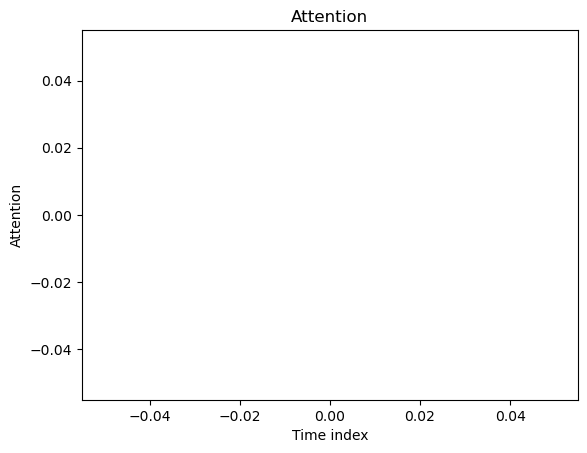

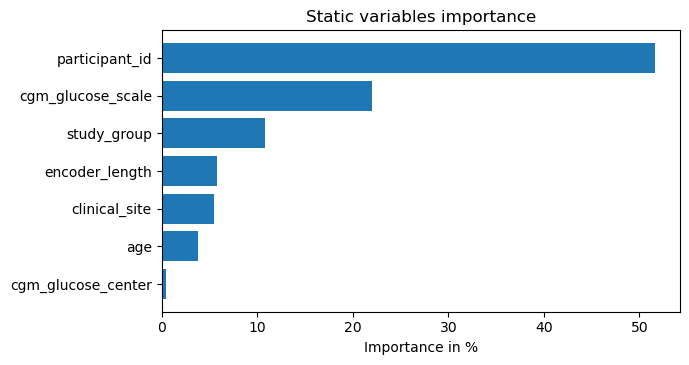

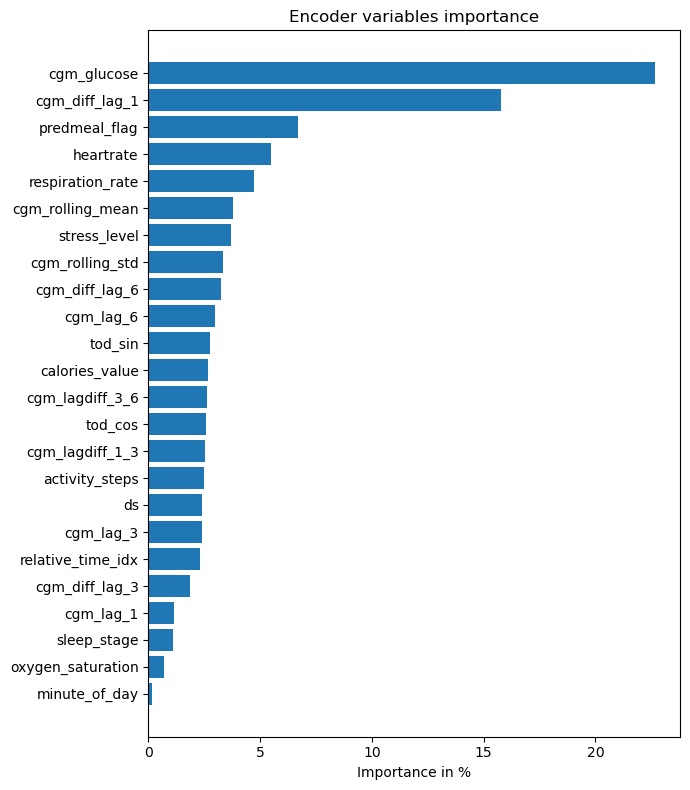

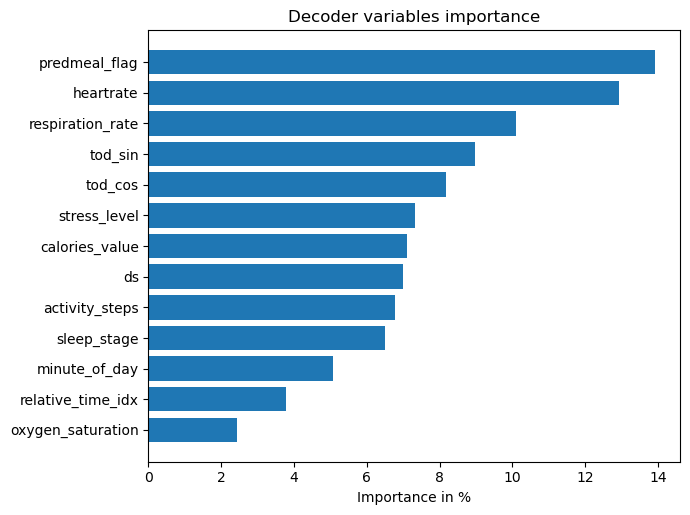

In [7]:
# --- Prédiction ---
# Assure-toi que val_dataloader est bien structuré
y_hat_raw = tft.predict(val_dataloader, mode="raw")
# --- Visualisation des interprétations ---
interpretation = tft.interpret_output(y_hat_raw, reduction="sum")
tft.plot_interpretation(interpretation)

In [11]:
# Get global metrics:
raw_preds = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
print("Shape of raw_preds:", raw_preds.output["prediction"].shape)
y_pred = raw_preds.output["prediction"][:, :, 1] #To get median quantile.
y_true = raw_preds.x["decoder_target"]
index_df = raw_preds.index
records = []
for i in range(len(index_df)):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    for t in range(y_pred.shape[1]):
        records.append({
            "participant_id": uid,
            "ds": int(time_start + t),
            "target": float(y_true[i, t]),
            "prediction": float(y_pred[i, t]),
        })
records = pd.DataFrame(records)

metricsCI = calculate_metrics_CI(records, train)
print(metricsCI)

# Save metrics locally
metricsCI.to_csv("./figures/metrics_mamba2_MES_288.csv", index=False)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Shape of raw_preds: torch.Size([741, 12, 3])
          Metric      Mean  Lower CI  Upper CI
0          SMAPE  4.336698  4.137037  4.536360
1            MAE  5.662179  5.392867  5.931491
2           RMSE  6.858839  6.530018  7.187659
3  Quantile_Loss  2.831089  2.696433  2.965746


/tmp/ipykernel_2481/1184106390.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [12]:
from pytorch_forecasting.metrics import QuantileLoss

loss_fn = QuantileLoss(quantiles=[0.1, 0.5, 0.9])  # uses same quantiles as model


# Usage with your tensors:
pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device

#Shape of pred:
print("Shape of pred:", pred.shape)

#Shape of true:
print("Shape of true:", true.shape)

print("Quantiles used in loss function:", tft.loss.quantiles)

val_loss = loss_fn(pred, true)
print("Validation Quantile Loss (using pytorch-forecasting):", val_loss.item())

Shape of pred: torch.Size([741, 12, 3])
Shape of true: torch.Size([741, 12])
Quantiles used in loss function: [0.1, 0.5, 0.9]
Validation Quantile Loss (using pytorch-forecasting): 3.6881818771362305


In [13]:
# Get confidence intervals for quantile loss

from pytorch_forecasting.metrics import QuantileLoss

# Keep individual losses
loss_fn = QuantileLoss(quantiles=[0.1, 0.5, 0.9], reduction="none").to(device)  # uses same quantiles as model

# Usage with your tensors:
pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device


losses = loss_fn(pred, true)  # shape: (B, T, Q)

import torch

# Flatten across batch, time, and quantiles
losses_flat = losses.view(-1).detach().cpu()

mean_loss = losses_flat.mean().item()
std_loss = losses_flat.std().item()

# 95% confidence interval (normal approximation)
n = losses_flat.numel()
ci95 = 1.96 * std_loss / (n**0.5)

print(f"Mean loss: {mean_loss:.4f} ± {ci95:.4f}")


print(f"Mean loss: {mean_loss - ci95}, {mean_loss + ci95}")

Mean loss: 3.6882 ± 0.0596
Mean loss: 3.6285681945647226, 3.7477955597077384


In [7]:
# --- Build test with encoder context ---
context_length = 288     # = max_encoder_length used in 'training'
horizon = 12             # = max_prediction_length used in 'training'
time_col = "ds"          # must match the 'time_idx' you used for 'training'
gid_col = "participant_id"

combined = []
for pid, test_part in test.groupby(gid_col):
    train_part = train.loc[train[gid_col].eq(pid)].sort_values(time_col)
    # if a participant exists only in test, skip or handle separately
    if train_part.empty:
        continue
    enc = train_part.tail(min(len(train_part), context_length))
    tmp = pd.concat([enc, test_part], axis=0).sort_values(time_col)
    # ensure integer, strictly increasing time index if required by your dataset
    # tmp[time_col] = tmp[time_col].astype(int)  # uncomment if needed
    combined.append(tmp)

test_full = pd.concat(combined, axis=0).reset_index(drop=True)

# --- Build dataset/dataloader (re-uses all settings from 'training') ---
from pytorch_forecasting import TimeSeriesDataSet

test_ds = TimeSeriesDataSet.from_dataset(
    training,
    test_full,
    stop_randomization=True,
    predict=True,            # create one prediction window per series
)

test_dl = test_ds.to_dataloader(train=False, batch_size=32)

# --- Predict ---
import torch
tft.eval()
with torch.no_grad():
    out = tft.predict(test_dl, mode="raw", return_x=True, return_index=True)

# pick median quantile robustly
# works if your loss is QuantileLoss and model exposes quantiles
quantiles = getattr(tft, "quantiles", [0.1, 0.5, 0.9])
q_median_idx = int(quantiles.index(0.5)) if 0.5 in quantiles else 0  # fallback

pred = out.output["prediction"][:, :, q_median_idx]          # (n_windows, horizon)
true = out.x["decoder_target"]                                # (n_windows, horizon)
idx  = out.index                                              # DataFrame with group ids + start time_idx

# --- Reconstruct long-form records for metrics ---
records = []
for i in range(len(idx)):
    pid = idx.iloc[i][gid_col]
    t0  = idx.iloc[i][time_col]  # this is the decoder start time (first forecast step)
    for t in range(pred.shape[1]):
        records.append({
            gid_col: pid,
            time_col: int(t0 + t),
            "target": float(true[i, t]),
            "prediction": float(pred[i, t]),
        })

records = pd.DataFrame(records)

# optional: sanity checks
# assert records.groupby([gid_col, time_col]).size().eq(1).all()

metricsCI = calculate_metrics_CI(records, train)
print(metricsCI)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


          Metric       Mean   Lower CI   Upper CI
0          SMAPE   8.619146   8.150760   9.087532
1            MAE  11.644033  10.897278  12.390789
2           RMSE  13.844692  12.994306  14.695077
3  Quantile_Loss   5.822017   5.448639   6.195394


/tmp/ipykernel_5774/1184106390.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


# Mamba-MES (2 day)

In [6]:
# Load Data
import os
import sys
import torch

# Fetch best ckpt from GCS (use your actual bucket/prefix)
BUCKET = "cgmproject2025"
GCS_PREFIX = "checkpoints_mamba576_MESv4"   # <- change if your run used a different folder
best_ckpt_path = download_best_ckpt_by_filename("checkpoints", BUCKET, GCS_PREFIX,
                                                run_prefix="mamba576_MES-", metric_key="val_loss")


#from TFT_pytorch import log_memory, create_tft_dataloaders, TFT_train
from scripts.mamba2_576_mesv4 import create_tft_dataloaders, TFT_train, save_tft_to_gcs, load_tft_from_gcs, MambaTFT


# param_48 = {
#     "dataset": {"context_length": 576, "horizon": 12, "batch_size": 32},
#     "mamba_tft_init": {"mamba_depth": 4, "mamba_dropout": 0.2},
#     "mamba_block": {
#         "d_model": 128,
#         "dropout": 0.2,
#         "return_hidden_attn": False,
#         "d_state": 128, #160,   # ↑ pour 48h (avant 128). Monte si sous-mémoire
#         "d_conv": 8, #12,
#         "expand": 4,
#         "headdim": 64,
#         "x_share_mode": "se",
#         "ngroups": 1      # 👈 idem
#     },
#     "mamba2_mes_runtime": {
#         "mes_diag": True,
#         "x_share_mode": "mean",
#         "chunk_size": 128, #512,
#         "dt_limit": (1e-3, 10.0),
#         "learnable_init_states": True,
#         "D": None
#     },
#     "checkpoint": {True}
# }

param_48 = {
    "dataset": {"context_length": 576, "horizon": 12, "batch_size": 32},
    "mamba_tft_init": {"mamba_depth": 4, "mamba_dropout": 0.2},
    "mamba_block": {
        "d_model": 128,
        "dropout": 0.2,
        "return_hidden_attn": False,
        "d_state": 128, #160,   # ↑ pour 48h (avant 128). Monte si sous-mémoire
        "d_conv": 8, #12,
        "expand": 4,
        "headdim": 64,
        "x_share_mode": "mean", #"se"
        "ngroups": 1      # 👈 idem
    },
    "mamba2_mes_runtime": {
        "mes_diag": True,
        "x_share_mode": "mean",
        "chunk_size": 128, #512,
        "dt_limit": (1e-3, 10.0),
        "learnable_init_states": True,
        "D": None
    },
    "checkpoint": {True}
}

training, val_dataloader, train_dataloader, validation = create_tft_dataloaders(train, horizon=12, context_length=576, batchsize=32)

# tft = load_tft_from_gcs(model_name="Mamba2_12h_288c_MES", training_dataset=training)
# tft.eval()  # Put model in evaluation mode

# Load model from the checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
tft = MambaTFT.load_from_checkpoint(best_ckpt_path, map_location=device).to(device)
tft.eval()

Downloaded best checkpoint: gs://cgmproject2025/checkpoints_mamba576_MESv4/mamba576_MES-epoch=19-val_loss=3.30.ckpt -> checkpoints/mamba576_MES-epoch=19-val_loss=3.30.ckpt


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[GPU] NVIDIA A100-SXM4-40GB  CC=(8, 0), BF16=OK
[2025-08-31 23:01:33.934546] 🚀 Start of Dataloader Creation
GPU Mem allocated: 0.00 GB | reserved: 0.00 GB


/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


MambaTFT(
  	"attention_head_size":               8
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'ds', 'target': 'cgm_glucose', 'group_ids': ['participant_id'], 'weight': None, 'max_encoder_length': 576, 'min_encoder_length': 576, 'min_prediction_idx': np.int64(11), 'min_prediction_length': 12, 'max_prediction_length': 12, 'static_categoricals': ['participant_id', 'clinical_site', 'study_group'], 'static_reals': ['age'], 'time_varying_known_categoricals': ['sleep_stage'], 'time_varying_known_reals': ['ds', 'minute_of_day', 'tod_sin', 'tod_cos', 'activity_steps', 'calories_value', 'heartrate', 'oxygen_saturation', 'respiration_rate', 'stress_level', 'predmeal_flag'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['cgm_glucose', 'cgm_lag_1', 'cgm_lag_3', 'cgm_lag_6', 'cgm_diff_lag_1', 'cgm_diff_lag_3', 'cgm_diff_lag_6', 'cgm_lagdiff_1_3', 'cgm_lagdiff_3_6', 'cgm_roll

In [15]:
# # --- Prédiction ---
# # Assure-toi que val_dataloader est bien structuré
# y_hat_raw = tft.predict(val_dataloader, mode="raw")
# # --- Visualisation des interprétations ---
# #interpretation = tft.interpret_output(y_hat_raw, reduction="sum")
# interpretation = tft.interpret_output(y_hat_raw, reduction="none")
# tft.plot_interpretation(interpretation)

In [7]:
# Get global metrics:
raw_preds = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
print("Shape of raw_preds:", raw_preds.output["prediction"].shape)
y_pred = raw_preds.output["prediction"][:, :, 1] #To get median quantile.
y_true = raw_preds.x["decoder_target"]
index_df = raw_preds.index
records = []
for i in range(len(index_df)):
    uid = index_df.iloc[i]["participant_id"]
    time_start = index_df.iloc[i]["ds"]
    for t in range(y_pred.shape[1]):
        records.append({
            "participant_id": uid,
            "ds": int(time_start + t),
            "target": float(y_true[i, t]),
            "prediction": float(y_pred[i, t]),
        })
records = pd.DataFrame(records)

metricsCI = calculate_metrics_CI(records, train)
print(metricsCI)

# Save metrics locally
metricsCI.to_csv("./figures/metrics_mamba2_MES_576.csv", index=False)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/shaksonisaac/miniconda3/envs/cgmall/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Shape of raw_preds: torch.Size([741, 12, 3])
          Metric      Mean  Lower CI  Upper CI
0          SMAPE  4.123248  3.935895  4.310601
1            MAE  5.399003  5.149707  5.648300
2           RMSE  6.560877  6.256018  6.865736
3  Quantile_Loss  2.699502  2.574854  2.824150


/tmp/ipykernel_2591/1184106390.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [8]:
from pytorch_forecasting.metrics import QuantileLoss

loss_fn = QuantileLoss(quantiles=[0.1, 0.5, 0.9])  # uses same quantiles as model


# Usage with your tensors:
pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device

#Shape of pred:
print("Shape of pred:", pred.shape)

#Shape of true:
print("Shape of true:", true.shape)

print("Quantiles used in loss function:", tft.loss.quantiles)

val_loss = loss_fn(pred, true)
print("Validation Quantile Loss (using pytorch-forecasting):", val_loss.item())

Shape of pred: torch.Size([741, 12, 3])
Shape of true: torch.Size([741, 12])
Quantiles used in loss function: [0.1, 0.5, 0.9]
Validation Quantile Loss (using pytorch-forecasting): 3.5230157375335693


In [9]:
# Get confidence intervals for quantile loss

from pytorch_forecasting.metrics import QuantileLoss

# Keep individual losses
loss_fn = QuantileLoss(quantiles=[0.1, 0.5, 0.9], reduction="none").to(device)  # uses same quantiles as model

# Usage with your tensors:
pred = raw_preds.output["prediction"]            # (B, T, Q) torch tensor on device
true = raw_preds.x["decoder_target"]             # (B, T)   torch tensor on device


losses = loss_fn(pred, true)  # shape: (B, T, Q)

import torch

# Flatten across batch, time, and quantiles
losses_flat = losses.view(-1).detach().cpu()

mean_loss = losses_flat.mean().item()
std_loss = losses_flat.std().item()

# 95% confidence interval (normal approximation)
n = losses_flat.numel()
ci95 = 1.96 * std_loss / (n**0.5)

print(f"Mean loss: {mean_loss:.4f} ± {ci95:.4f}")


print(f"Mean loss: {mean_loss - ci95}, {mean_loss + ci95}")


Mean loss: 3.5230 ± 0.0578
Mean loss: 3.4652273282588153, 3.5808041468083234
